In [4]:
import pandas as pd
import json
import os
from tqdm import tqdm  # Ensure tqdm is imported correctly

In [ ]:
df = pd.read_csv('docs/t20s_2013-23_mgd.csv').drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

In [ ]:
player_ids=df[['p_bat', 'p_bowl']].stack().drop_duplicates()
len(player_ids)

In [ ]:
import requests

def get_country_name(player_id):
    # Format the URL with the given player_id
    url = "https://hs-consumer-api.espncricinfo.com/v1/pages/player/home?playerId={0}".format(str(player_id))
    
    # Define headers to mimic a browser request
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    try:
        # Make an HTTP GET request to the URL with headers
        response = requests.get(url, headers=headers)
        
        # Check if the request was successful
        if response.status_code == 200:
            # Parse the JSON response
            data = response.json()
            
            # Safely extract the country name
            country_name = data.get('player', {}).get('country', {}).get('name', "Country name not found")
            return country_name
        else:
            return f"Failed to retrieve data from the API. Status code: {response.status_code}"
    
    except requests.exceptions.RequestException as e:
        # Catch network-related errors
        return f"Failed due to a request error: {str(e)}"
    
    except Exception as e:
        # Catch all other exceptions
        return f"An unexpected error occurred: {str(e)}"


In [5]:
# Function to save the results incrementally to JSON
def save_to_json(data, filename="data/player_country_data.json"):
    # Open file in append mode and write the new batch of data
    with open(filename, "a") as json_file:
        json.dump(data, json_file)
        json_file.write("\n")  # Ensure each dictionary is written on a new line

# Dictionary to store player countries
player_country_dict = {}

# Processing all player IDs at once
print("Processing all players...")

# Temporary dictionary to store results for all players
batch_country_dict = {}

for player_id in tqdm(player_ids, desc="Processing Players"):
    country_name = get_country_name(player_id)
    batch_country_dict[player_id] = country_name

# Save all results to the main dictionary
player_country_dict.update(batch_country_dict)

# Save all player data to JSON file
save_to_json(batch_country_dict)

print("All players processed and saved.")

Processing all players...


NameError: name 'player_ids' is not defined

In [6]:
df1 = pd.read_excel("data/batters_against_bowlingtype.xlsx")
df2 = pd.read_excel("data/Bowling_against_left_right_handers.xlsx")
df3 = pd.read_csv("data/batting_stats.csv")
df4 = pd.read_csv("data/bowling_stats.csv")

In [16]:
with open('data/player_country_data.json', 'r') as file:
    json_data = json.load(file)

In [30]:
df1['Country']=df1['player_id'].astype(str).map(json_data)
df2['Country']=df2['player_id'].astype(str).map(json_data)
df3['Country']=df3['player_id'].astype(str).map(json_data)
df4['Country']=df4['player_id'].astype(str).map(json_data)

In [29]:
df1.to_excel("data/batters_against_bowlingtype.xlsx", index=False)
df2.to_excel("data/Bowling_against_left_right_handers.xlsx", index=False)
df3.to_csv("data/batting_stats.csv", index=False)
df4.to_csv("data/bowling_stats.csv", index=False)

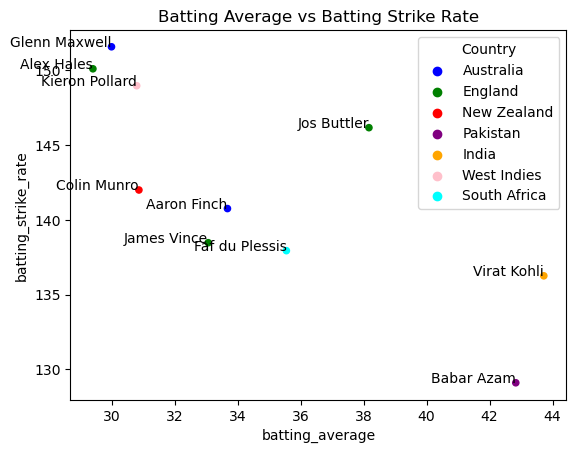

In [43]:
top_10 = df3[df3['runs_scored'] > 1000].sort_values(by='runs_scored', ascending=False).head(10)
colors = top_10['Country'].map({'Australia': 'blue', 'England': 'green', 'New Zealand': 'red', 'Pakistan': 'purple', 'India': 'orange', 'West Indies': 'pink', 'South Africa': 'cyan'})
ax = top_10.plot(kind='scatter', x='batting_average', y='batting_strike_rate', c=colors, title='Batting Average vs Batting Strike Rate')
for i, row in top_10.iterrows(): ax.text(row['batting_average'], row['batting_strike_rate'], row['batsman'], ha='right')
for country, color in {'Australia': 'blue', 'England': 'green', 'New Zealand': 'red', 'Pakistan': 'purple', 'India': 'orange', 'West Indies': 'pink', 'South Africa': 'cyan'}.items():
    ax.scatter([], [], c=color, label=country)
ax.legend(title='Country')
